In [1]:
from pyqumo.algorithms.networks import mapph1n_tandem
from pyqumo.random import PhaseType, Exponential
from pyqumo.arrivals import MarkovArrival
from pyqumo.cqumo.sim import simulate_tandem

import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
import locale
import os

import numpy as np

In [2]:
def setup_matplotlib() -> None:
    """
    Настроить параметры matplotlib и локали.
    """
    matplotlib.rcParams.update({
        'image.cmap': 'viridis',
        'axes.formatter.use_locale': True,
        'font.size': 16,
        'font.family': 'sans-serif',
        'axes.titlesize': 'medium',
        'figure.titlesize': 'medium',
    })

    locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8')

setup_matplotlib()

In [3]:
from IPython.display import display, Math

def print_matrix(array):
    data = ''
    for line in array:        
        if len(line) == 1:
            data += ' %.3g &'%line + r' \\\n'
            continue
        for element in line:
            data += ' %.3g &'%element
        data += r' \\' + '\n'
    display(Math('\\begin{bmatrix} \n%s\end{bmatrix}'%data))

## Сравнение времени рассчета имитационной и аналитической моделей

В первом численном эксперименте сравним точность и скорость получения численных результатов с помощью симуляции, а точное решение будем находить с помощью матричного метода. Из-за экспоненциального взрыва пространства состояний и необходимости найти точное решение, приходится ограничиваться простейшими экспоненциальными распределениями и сетями небольшого размера.

Рассмотрим сеть массового обслуживания с пуассоновским потоком с интенсивностью $\lambda = 1$, поступающим на первый узел. Обслуживание на всех узлах будем иметь экспоненциальное распределение с интенсивностью $\mu = 2$, емкость очередей равна $K = 2$. Число узлов в сети $N$ будем варьировать от $N_{min} = 1$ до $N_{max} = 6$. Выходной поток после обслуживания на первом узле (системе типа M/M/1/K) будет MAP с матрицами (**!!!проверить!!!**):

$$
D_0 = \begin{pmatrix}
-1 & 1 & 0 & 0 \\
0 & -3 & 1 & 0 \\
0 & 0 & -3 & 1 \\
0 & 0 & 0 & -2
\end{pmatrix}\qquad
D_1 = \begin{pmatrix}
0 & 0 & 0 & 0\\
2 & 0 & 0 & 0\\
0 & 2 & 0 & 0\\
0 & 0 & 2 & 0
\end{pmatrix}
$$

Соответственно, на второй узел поступает MAP-поток, этот узел имеет тип MAP/M/1/K. Выходные потоки со второго и всех последующих узлов будут MAP, размерность которых экспоненциально увеличивается. Более точно, размерность матрицы выходящего потока с $N$-го узла есть $4^N$.

Точность численных результатов, полученных с помощью симуляции в пакете `pyqumo`, зависит от числа моделируемых пакетов. Будем рассматривать случай быстрой симуляции с моделированием 1'000 пакетов, а также случай получения более точных результатов с моделированием 50'000 пакетов. В обоих случаях будем выполнять симуляцию многократно (по 20 итераций для каждого размера сети), усреднять результаты и измерять вариацию оценок, полученных на разных итерациях.

In [4]:
def current_milli_time():
    return round(time.time() * 1000)

In [5]:
BASIC_INP = {
    'arrival': MarkovArrival.poisson(1),
    'service': PhaseType.exponential(2),
    'capacity': 2,
    'max_net_size': 6,
    'max_packets_rough': 1_000,
    'max_packets_precise': 50_000,
}

N_ITERS = 20


In [6]:
BASIC_DELAYS = {'sim_precise': [], 'sim_rough': [], 'analytic': []}
BASIC_DURATIONS = {'sim_precise': [], 'sim_rough': [], 'analytic': []}
BASIC_DELAY_STDS = {'sim_precise': [], 'sim_rough': [], 'analytic': []}

for net_size in tqdm(range(1, BASIC_INP['max_net_size']+1)):
    ana_delays, ana_durations = [], []
    sim_rough_delays, sim_rough_durations = [], []
    sim_precise_delays, sim_precise_durations = [], []
    
    for n in range(N_ITERS):
        t0 = time.time()
        ana_ret = mapph1n_tandem.solve_iterative(
            BASIC_INP['arrival'], 
            BASIC_INP['service'], 
            BASIC_INP['capacity'],
            net_size
        )
        ana_durations.append(time.time() - t0)
        ana_delays.append(ana_ret.delay)
        
        t0 = time.time()
        sim_ret = simulate_tandem(
            BASIC_INP['arrival'], 
            [BASIC_INP['service'].copy() for _ in range(net_size)], 
            BASIC_INP['capacity'], 
            BASIC_INP['max_packets_rough']
        )
        sim_rough_durations.append(time.time() - t0)
        sim_rough_delays.append(sim_ret.delivery_delays[0].avg)

        t0 = time.time()
        sim_ret = simulate_tandem(
            BASIC_INP['arrival'], 
            [BASIC_INP['service'].copy() for _ in range(net_size)], 
            BASIC_INP['capacity'], 
            BASIC_INP['max_packets_precise']
        )
        sim_precise_durations.append(time.time() - t0)
        sim_precise_delays.append(sim_ret.delivery_delays[0].avg)
        
    mean_precise_delay = np.mean(sim_precise_delays)
    std_precise_delay = np.std(sim_precise_delays)
    mean_rough_delay = np.mean(sim_rough_delays)
    std_rough_delay = np.std(sim_rough_delays)
    mean_ana_delay = np.mean(ana_delays)
    std_ana_delay = np.std(ana_delays)

    BASIC_DELAYS['sim_rough'].append(mean_rough_delay)
    BASIC_DELAYS['sim_precise'].append(mean_precise_delay)
    BASIC_DELAYS['analytic'].append(mean_ana_delay)
    
    BASIC_DURATIONS['sim_rough'].append(np.mean(sim_rough_durations))
    BASIC_DURATIONS['sim_precise'].append(np.mean(sim_precise_durations))
    BASIC_DURATIONS['analytic'].append(np.mean(ana_durations))
    
    BASIC_DELAY_STDS['sim_precise'].append(std_precise_delay / mean_precise_delay)
    BASIC_DELAY_STDS['sim_rough'].append(std_rough_delay / mean_rough_delay)
    BASIC_DELAY_STDS['analytic'].append(std_ana_delay / mean_ana_delay)

print("DURATIONS:")
print(BASIC_DURATIONS)
print("DELAYS:")
print(BASIC_DELAYS)
print("DELAY STDS:")
print(BASIC_DELAY_STDS)

  0%|          | 0/6 [00:00<?, ?it/s]

DURATIONS:
{'sim_precise': [0.042234277725219725, 0.06605087518692017, 0.0885932445526123, 0.11249321699142456, 0.1342908263206482, 0.16005691289901733], 'sim_rough': [0.0013001441955566406, 0.0020513176918029786, 0.0028021574020385743, 0.003615999221801758, 0.004257464408874511, 0.006102299690246582], 'analytic': [0.0006976842880249024, 0.001797783374786377, 0.01009838581085205, 0.02583928108215332, 0.24420105218887328, 7.698344433307648]}
DELAYS:
{'sim_precise': [0.7871351997442236, 1.5580796752030384, 2.327636694801725, 3.0673849186708986, 3.8201584725779005, 4.560029242643653], 'sim_rough': [0.7828216243863827, 1.5424121853062802, 2.306927833019151, 3.0892991243674635, 3.8272421989619465, 4.538644848292413], 'analytic': [0.7857142857142859, 1.5460990113372897, 2.290901740811164, 3.0243156374657323, 3.7487188969295318, 4.465657706184042]}
DELAY STDS:
{'sim_precise': [0.0063387504180163435, 0.005064953280159947, 0.003354728353645706, 0.0035843088307631393, 0.003945302692304407, 0.002

In [7]:
np.std([1, 2, 4])

1.247219128924647

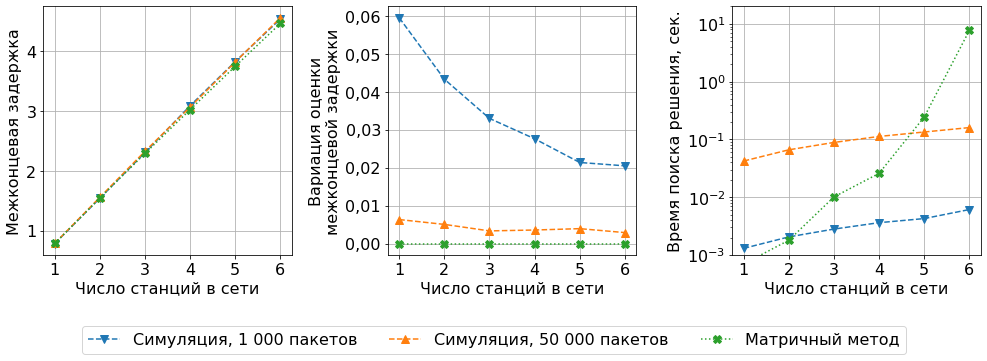

In [8]:
OX = np.arange(1, BASIC_INP['max_net_size']+1)
SIM_ROUGH_STYLE   = {'linestyle': '--', 'marker': 'v', 'markersize': 8,
                     'label': f'Симуляция, {BASIC_INP["max_packets_rough"]:n} пакетов'}
SIM_PRECISE_STYLE = {'linestyle': '--', 'marker': '^', 'markersize': 8,
                     'label': f'Симуляция, {BASIC_INP["max_packets_precise"]:n} пакетов'}
ANALYTIC_STYLE    = {'linestyle': ':', 'marker': 'X', 'markersize': 8,
                     'label': f'Матричный метод'}

fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
axes[0].plot(OX, BASIC_DELAYS['sim_rough'], **SIM_ROUGH_STYLE)
axes[0].plot(OX, BASIC_DELAYS['sim_precise'], **SIM_PRECISE_STYLE)
axes[0].plot(OX, BASIC_DELAYS['analytic'], **ANALYTIC_STYLE)
axes[0].set_ylabel('Межконцевая задержка')

axes[1].plot(OX, BASIC_DELAY_STDS['sim_rough'], **SIM_ROUGH_STYLE)
axes[1].plot(OX, BASIC_DELAY_STDS['sim_precise'], **SIM_PRECISE_STYLE)
axes[1].plot(OX, BASIC_DELAY_STDS['analytic'], **ANALYTIC_STYLE)
axes[1].set_ylabel('Вариация оценки\nмежконцевой задержки')

axes[2].plot(OX, BASIC_DURATIONS['sim_rough'], **SIM_ROUGH_STYLE)
axes[2].plot(OX, BASIC_DURATIONS['sim_precise'], **SIM_PRECISE_STYLE)
axes[2].plot(OX, BASIC_DURATIONS['analytic'], **ANALYTIC_STYLE)
axes[2].set_ylabel('Время поиска решения, сек.')
axes[2].set_yscale('log')
axes[2].set_ylim((0.001, 20))

for i, ax in enumerate(axes):
    ax.grid()
    ax.set_xticks(OX)
    ax.set_xlabel('Число станций в сети')

fig.legend(*axes[0].get_legend_handles_labels(), 
           loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
fig.savefig(os.path.join("images", "olga_mm1n.pdf"), bbox_inches="tight")

На графиках показаны зависимости межконцевых задержек от числа станций в сети, время, затраченное на писк решения, а также вариация численных оценок, полученных на разных итерациях. Можно видеть, что точность оценки средней межконцевой задержки оказывается достаточно высокой даже при моделировании всего 1000 пакетов, однако вариация оценки оказывается высокой (до 6%), то есть при однократном выполнении симуляции оценка может достаточно сильно отклоняться. При моделировании 50'000 пакетов вариация мала. 

Время вычисления с помощью матричного метода растет экспоненциально, как и размерность выходящих потоков. Для систем малого размера вычисление матричным методом оказывается быстрее симуляции, однако уже для сетей с $N = 5$ станциями симуляция работает быстрее. Время, требуемое для выполнения симуляции, пропорционально числу моделируемых пакетов, и зависит почти линейно от числа станций в сети. Таким образом, для получения численных оценок характеристик сети большой размерности симуляция оказывается единственным практически применимым методом.

## Расчет характеристик системы с произвольными распределениями

Пакет `pyqumo` позволяет вычислять оценки сетей массового обслуживания с входящими MAP-потоками и PH-распределениями с помощью матричного метода и имитационного моделирования. В качестве более общего примера рассмотрим сеть, в которой входящий $\text{MAP}(D_0, D_1)$:

$$
D_0 = \begin{pmatrix}
-1 & 0.4 & 0\\
1 & -1 & 0\\
0,2 & 0 & -200
\end{pmatrix}\qquad
D_1 = \begin{pmatrix}
0,58 & 0 & 0,02\\
0 & 0 & 0\\
0 & 0 & 199.8
\end{pmatrix},
$$

а в качестве PH-распределения $\text{PH}(S, \vec{p})$ используется гиперэрланговское распредеделение:

$$
S = \begin{pmatrix}
-100 &  100 &   0   &  0    &    0  &   0   \\
  0  & -100 &  100  &  0    &    0  &   0   \\
  0  &   0  & -100  &  0    &    0  &   0   \\
  0  &   0  &   0   & -10^5 &  10^5 &   0   \\
  0  &   0  &   0   &  0    & -10^5 &  10^5 \\
  0  &   0  &   0   &  0    &    0  & -10^5
\end{pmatrix}\qquad
\vec{p}^T = \begin{pmatrix}
0,9 \\
0   \\
0   \\
0,1 \\
0   \\
0
\end{pmatrix}
$$.

Емкость очереди будем полагать равной $K = 2$. 

Рассматриваемый MAP-поток имеет среднюю интенсивность $\lambda \approx 13,72$, коэффициент вариации $c_a \approx 8,13$ и коэффициент корреляции (с лагом 1) $\rho_1 \approx 0,422$. Интенсивность обслуживания $\mu \approx 37,033$, коэффициент вариации длительности обслуживания $c_s \approx 0,694$.

Размерность выходящего потока с первого узла моделируемой сети равна $72 = 3 \bullet 6 \bullet (2 + 2)$. Выходящий поток со второго узла уже будет иметь $1728$ состояний, а с третьего - $41'472$ состояний. Из-за столь быстрого роста размерности задачи ограничим применение матричного метода сетью длины $N = 2$. С помощью симуляции найдем оценки межконцевых задержек для сетей большего размера, вплоть до $N_{max} = 10$.

In [25]:
S = np.asarray([
    [-100, 100, 0, 0, 0, 0],
    [0, -100, 100, 0, 0, 0],
    [0, 0, -100, 0, 0, 0],
    [0, 0, 0, -100_000, 100_000, 0],
    [0, 0, 0, 0, -100_000, 100_000],
    [0, 0, 0, 0, 0, -100_000]
])
p = np.asarray([0.9, 0, 0, 0.1, 0, 0])

PH = PhaseType(S, p)
print(f"Mean: {PH.mean:.3f}\n"
      f"Std : {PH.std:.3f}\n"
      f"CV  : {PH.cv:.3f}\n"
      f"Rate: {PH.rate:.3f}")
print("S:")
print_matrix(S)
print("tau:")
print_matrix(p.reshape((1, len(p))))

Mean: 0.027
Std : 0.019
CV  : 0.694
Rate: 37.033
S:


<IPython.core.display.Math object>

tau:


<IPython.core.display.Math object>

In [26]:
D0 = np.asarray([
    [-1, 0.4, 0],
    [1, -1, 0],
    [0.2, 0, -200]
])
D1 = np.asarray([
    [0.58, 0, 0.02],
    [0, 0, 0],
    [0, 0, 199.8]
])

MAP = MarkovArrival(D0, D1)
print(f"Mean: {MAP.mean:.3f}\n"
      f"Std : {MAP.std:.3f}\n"
      f"CV  : {MAP.cv:.3f}\n"
      f"Rate: {MAP.rate:.3f}\n"
      f"Corr: {MAP.lag(1)}")

print("D0:")
print_matrix(D0)

print("D1:")
print_matrix(D1)

Mean: 0.073
Std : 0.593
CV  : 8.130
Rate: 13.720
Corr: 0.42208306174254717
D0:


<IPython.core.display.Math object>

D1:


<IPython.core.display.Math object>

In [27]:
CAPACITY = 2

In [51]:
def compute_analytic_delay(arrival, service, capacity, net_size):
    t0 = time.time()
    ret = mapph1n_tandem.solve_iterative(MAP, PH, capacity, net_size, max_precise_order=100000)
    elapsed = time.time() - t0
    return ret.delay, elapsed

def compute_simulation_delay(arrival, service, capacity, net_size, max_packets=50_000):
    t0 = time.time()
    sim_ret = simulate_tandem(arrival, [service.copy() for _ in range(net_size)], capacity, max_packets)
    elapsed = time.time() - t0
    return sim_ret.delivery_delays[0].avg, elapsed

In [52]:
MAX_ANA_NET_SIZE = 2
ANA_COMPLEX_DELAYS, ANA_COMPLEX_ELAPSED = [], []

for n in range(1, MAX_ANA_NET_SIZE+1):
    d, e = compute_analytic_delay(MAP, PH, CAPACITY, n)
    ANA_COMPLEX_DELAYS.append(d)
    ANA_COMPLEX_ELAPSED.append(e)

print(ANA_COMPLEX_DELAYS)
print(ANA_COMPLEX_ELAPSED)

[0.06866484045420225, 0.11594086850479109]
[0.016666412353515625, 1.9080116748809814]


In [56]:
MAX_SIM_NET_SIZE = 10
MAX_SIM_PACKETS = 50_000
MAX_SIM_ITERS = 10
SIM_COMPLEX_DELAYS, SIM_COMPLEX_ELAPSED = [], []

for n in range(1, MAX_SIM_NET_SIZE+1):
    for _ in range(MAX_SIM_ITERS):
        delays, elapsed = [], []
        d, e = compute_simulation_delay(MAP, PH, CAPACITY, n, MAX_SIM_PACKETS)
        delays.append(d)
        elapsed.append(e)
    
    SIM_COMPLEX_DELAYS.append(np.mean(delays))
    SIM_COMPLEX_ELAPSED.append(np.mean(elapsed))

print(SIM_COMPLEX_DELAYS)
print(SIM_COMPLEX_ELAPSED)

[0.07042246397904364, 0.11771721944652176, 0.16277678448052377, 0.20329769593642125, 0.23953098370637643, 0.28813612477994954, 0.32838552271141, 0.3588455809083046, 0.4005654268152447, 0.43859327065135567]
[0.024000167846679688, 0.03099966049194336, 0.037001848220825195, 0.044997453689575195, 0.05000114440917969, 0.05499744415283203, 0.06000018119812012, 0.06700825691223145, 0.07397055625915527, 0.07699918746948242]


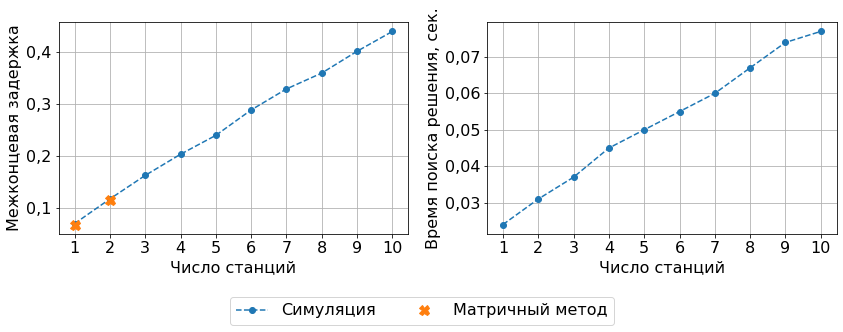

In [70]:
OX = np.arange(1, MAX_SIM_NET_SIZE + 1)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

SIM_STYLE      = {'linestyle': '--', 'marker': 'o', 'markersize': 6, 'label': f'Симуляция'}
ANA_STYLE      = {'linestyle': '', 'marker': 'X', 'markersize': 10, 'label': f'Матричный метод'}

ax0.plot(OX, SIM_COMPLEX_DELAYS, **SIM_STYLE)
ax0.plot(np.arange(1, MAX_ANA_NET_SIZE+1), ANA_COMPLEX_DELAYS, **ANA_STYLE)
ax0.set_ylabel("Межконцевая задержка")

ax1.plot(OX, SIM_COMPLEX_ELAPSED, **SIM_STYLE)
# ax1.plot(np.arange(1, MAX_ANA_NET_SIZE+1), ANA_COMPLEX_ELAPSED, **ANA_STYLE)
ax1.set_ylabel('Время поиска решения, сек.')

for ax in (ax0, ax1):
    ax.grid()
    ax.set_xticks(OX)
    ax.set_xlabel("Число станций")

plt.tight_layout()
fig.legend(*ax0.get_legend_handles_labels(), 
           loc='lower center', bbox_to_anchor=(0.5, -0.14), ncol=3)

fig.savefig(os.path.join("images", "olga_mapph1n.pdf"), bbox_inches="tight")

На графике показана зависимость межконцевой задержки от числа станций, а также время, которое требовалось на выполнение симуляции. При каждом выполнении симуляции моделировалось по $50'000$ пакетов. Для сетей длины $N = 1, 2$ решение также было найдено матричным методом. Как показано на графике, оценки, полученные матричным методом и с помощью симуляции практически идентичны. 

Отметим, что на выполнение расчета матричным методом для сети длины $N = 1$ потребовалось $0,11$ сек., а для сети длины $N = 2$ потребовалось $1,9$ сек. Попытка получить оценки для сети длины $N = 3$ привели к переполнению оперативной памяти.